<a href="https://colab.research.google.com/github/jhcool1988/teamdata/blob/master/marketpredmachine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install catboost

In [23]:
#Installation of required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [136]:
sal = pd.read_csv('https://raw.githubusercontent.com/jhcool1988/teamdata/master/soccerVFm.csv')
sal.head(5)

# 파운드 물가상승률 반영

,playername,mvpr,marketvaluepound,season,age,lgrank,MP,starts,min,goal,assist,sh,sot,sotp,gsh,cmp,cmpp,crs,int,block,sca,passlive,drib,gca,gcapasslive,tkl,press,pressp,touches,succp,targ,rec,recp,miscon,fls,recov,aerialwonp
0,Lionel Messi,1.538937e+08,162000000,2018,30,1,36,32,3002,34,12,194.0,92.0,47.4,2.00,1532,78.7,53,62,80.0,234,134,39,43,24,13,413,29.3,2447,71.9,2445,2051,83.9,62,17,150,38.5
1,Lionel Messi,9.239972e+07,100800000,2020,32,2,33,32,2880,25,20,154.0,63.0,40.9,5.00,1700,79.4,113,61,62.0,220,126,37,36,22,14,287,30.3,2615,67.0,2616,2229,85.2,65,20,127,60.0
2,Allan Saint-Maximin,2.099619e+07,22500000,2019,21,7,34,34,2900,5,3,73.0,17.0,23.3,0.05,718,74.1,81,21,NaN,143,76,35,11,6,11,321,22.1,1466,64.1,1624,1181,72.7,117,12,176,44.4
3,Lionel Messi,1.259771e+08,135000000,2019,31,1,34,29,2713,36,13,167.0,85.0,50.9,4.00,1524,78.6,78,66,63.0,220,130,35,36,20,15,324,28.1,2395,61.3,2437,2046,84.0,51,22,131,30.0
4,Sofiane Boufal,8.398475e+06,9000000,2019,24,17,35,25,2085,3,3,50.0,17.0,34.0,0.06,674,76.2,60,21,NaN,110,54,29,13,7,33,469,24.3,1303,66.1,1184,975,82.3,66,42,165,53.6


In [137]:
sal = sal[['mvpr','goal','assist','sh','int','drib']]
sal.head(5)

,mvpr,goal,assist,sh,int,drib
0,1.538937e+08,34,12,194.0,62,39
1,9.239972e+07,25,20,154.0,61,37
2,2.099619e+07,5,3,73.0,21,35
3,1.259771e+08,36,13,167.0,66,35
4,8.398475e+06,3,3,50.0,21,29


In [26]:
models = []
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP',MLPRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('GBM', GradientBoostingRegressor()))
models.append(("XGBoost", XGBRegressor()))
models.append(("LightGBM", LGBMRegressor()))
models.append(("CatBoost", CatBoostRegressor(verbose = False)))

In [27]:
y = sal["mvpr"]
X = sal.drop("mvpr", axis=1)
cols = X.columns
cols


Index(['goal', 'assist', 'sh', 'int', 'drib'], dtype='object')

In [ ]:
X = X.dropna(inplace=False, axis=0)
print(X)

      goal  assist    sh   int  drib
0      3.0     1.0  38.0   4.0   3.0
1      4.0     3.0  29.0  30.0   0.0
2      3.0     1.0  39.0  38.0   2.0
3      2.0     2.0  33.0  19.0   3.0
4      1.0     3.0  19.0  14.0   6.0
...    ...     ...   ...   ...   ...
1551   4.0     2.0  37.8  17.0   2.0
1552   3.0     2.0  21.4  13.0   2.0
1553   8.0     2.0  45.7  13.0   5.0
1555  30.0     7.0  41.3  30.0  10.0
1556  10.0     5.0  31.3  22.0   3.0

[1185 rows x 5 columns]


In [28]:
#Feature Selection
#Wrapper Method
#Backward Elimination

import statsmodels.api as sm
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['goal', 'assist', 'sh', 'int', 'drib']


In [29]:
y = sal["mvpr"]
X = sal[selected_features_BE]

In [30]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=46)

In [31]:
for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        msg = "%s: (%f)" % (name, rmse)
        print(msg)

KNN: (18918030.060612)
SVR: (25711422.037997)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP: (30506598.975131)
CART: (22698995.987510)
RF: (17633379.959758)
GBM: (17489642.430099)
[15:25:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost: (17930866.724962)
LightGBM: (19676104.747404)
CatBoost: (18090382.912884)


# KNN

In [32]:
knn_params = {"n_neighbors": np.arange(1,30,1)}

knn_model = KNeighborsRegressor()

knn_cv_model = GridSearchCV(knn_model, knn_params, cv = 10).fit(X_train, y_train)

In [33]:
knn_cv_model.best_params_

{'n_neighbors': 28}

In [34]:
knn_tuned = KNeighborsRegressor(**knn_cv_model.best_params_).fit(X_train, y_train)

In [35]:
y_pred = knn_tuned.predict(X_test)
knn_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
knn_tuned_score

18398248.689758003

# SVR

In [36]:
svr_model = SVR() 

svr_params = {"C": [0.01, 0.1,0.3,0.5,0.8,1,5, 10, 50, 100,500,1000,10000]}

svr_cv_model = GridSearchCV(svr_model, svr_params, cv = 10, n_jobs = -1, verbose =  2).fit(X_train, y_train)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    6.6s finished


In [37]:
svr_cv_model.best_params_

{'C': 10000}

In [38]:
svr_tuned = SVR(**svr_cv_model.best_params_).fit(X_train, y_train)

In [39]:
y_pred = svr_tuned.predict(X_test)
svr_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
svr_tuned_score

25369845.358923674

# cart

In [40]:
cart_params = {"max_depth": [2,3,4,5,6,8,10,20,30,50, 100, 500, 1000,5000,10000],
              "min_samples_split": [2,5,10,20,30,50,100,500,1000,5000,10000]}

In [41]:
cart_model = DecisionTreeRegressor()

In [42]:
cart_cv_model = GridSearchCV(cart_model, cart_params, cv = 10).fit(X_train, y_train)

In [43]:
cart_cv_model.best_params_

{'max_depth': 4, 'min_samples_split': 20}

In [44]:
cart_tuned = DecisionTreeRegressor(**cart_cv_model.best_params_).fit(X_train, y_train)

In [45]:
y_pred = cart_tuned.predict(X_test)
cart_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
cart_tuned_score

18619992.077885404

# randomforest

In [125]:
rf_params = {"max_depth": [5,10,None],
            "max_features": [2,5,10],
            "n_estimators": [100, 500, 1000],
            "min_samples_split": [2,10,30]}

In [126]:
rf_model = RandomForestRegressor(random_state = 42).fit(X_train, y_train)

In [48]:
rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  8.5min finished


In [49]:
rf_cv_model.best_params_

{'max_depth': 5,
 'max_features': 2,
 'min_samples_split': 30,
 'n_estimators': 1000}

In [50]:
rf_tuned = RandomForestRegressor(max_depth=30,
            max_features=3,
            n_estimators=1000,
            min_samples_split=3).fit(X_train, y_train)

In [51]:
y_pred = rf_tuned.predict(X_test)
rf_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
rf_tuned_score

17258794.684491023

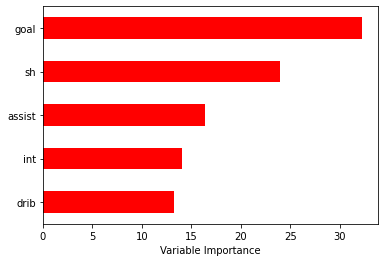

In [52]:
Importance = pd.DataFrame({'Importance':rf_tuned.feature_importances_*100}, 
                          index = cols)


Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# gbm

In [53]:
gbm_params = {"learning_rate": [0.001,0.1,0.01],
             "max_depth": [3,5,8],
             "n_estimators": [200,500,1000],
             "subsample": [1,0.5,0.8]
             }

In [54]:
gbm_model = GradientBoostingRegressor()

In [55]:
gbm_cv_model = GridSearchCV(gbm_model, 
                            gbm_params, 
                            cv = 10, 
                            n_jobs=-1, 
                            verbose = 2).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  7.1min finished


In [56]:
gbm_cv_model.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}

In [57]:
gbm_tuned = GradientBoostingRegressor(**gbm_cv_model.best_params_).fit(X_train, y_train)

In [58]:
y_pred = gbm_tuned.predict(X_test)
gbm_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
gbm_tuned_score

17422110.3052677

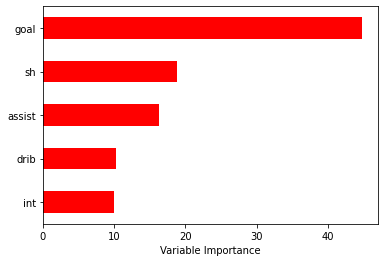

In [59]:
Importance = pd.DataFrame({'Importance':gbm_tuned.feature_importances_*100}, 
                          index = cols)


Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# xgb

In [60]:
xgb_params = {"learning_rate": [0.1,0.01,1],
             "max_depth": [2,5,8],
             "n_estimators": [100,500,1000],
             "colsample_bytree": [0.3,0.6,1]}

In [61]:
xgb = XGBRegressor()

In [62]:
xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 10, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:  2.2min


[15:48:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  2.8min finished


In [63]:
xgb_cv_model.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 500}

In [64]:
xgb_tuned = XGBRegressor(**xgb_cv_model.best_params_).fit(X_train, y_train)

[15:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [65]:
y_pred = xgb_tuned.predict(X_test)
xgb_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_tuned_score

17453482.084264208

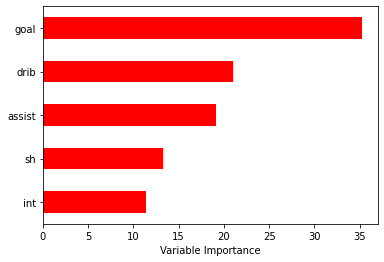

In [66]:
Importance = pd.DataFrame({'Importance':xgb_tuned.feature_importances_*100}, 
                          index = cols)


Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# lgbm


In [67]:
lgb_model = LGBMRegressor()

In [68]:
lgbm_params = {"learning_rate": [0.01, 0.1, 1],
              "n_estimators": [200,1000,10000],
              "max_depth": [2,5,10],
              "colsample_bytree": [1,0.5,0.3]}

In [69]:
lgbm_cv_model = GridSearchCV(lgb_model, 
                             lgbm_params, 
                             cv = 10, 
                             n_jobs = -1, 
                             verbose =2).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 383 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  9.2min finished


In [70]:
lgbm_cv_model.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 200}

In [71]:
lgbm_tuned = LGBMRegressor(learning_rate=0.01,
              n_estimators=300,
              max_depth=5,
              colsample_bytree=1).fit(X_train, y_train)

In [72]:
y_pred = lgbm_tuned.predict(X_test)
lgbm_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
lgbm_tuned_score

18805459.37889047

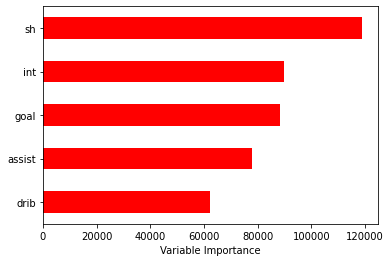

In [73]:
Importance = pd.DataFrame({'Importance':lgbm_tuned.feature_importances_*100}, 
                          index = cols)


Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

#catb

In [74]:
catb_model = CatBoostRegressor(verbose = False)

In [75]:
catb_params = {"iterations": [500,1000,10000],
              "learning_rate": [0.01,0.1,1],
              "depth": [2,6,10]}

In [76]:
catb_cv_model = GridSearchCV(catb_model, 
                           catb_params, 
                           cv = 2, 
                           n_jobs = -1, 
                           verbose = 2).fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  6.5min finished


In [77]:
catb_cv_model.best_params_

{'depth': 2, 'iterations': 1000, 'learning_rate': 0.01}

In [78]:
catb_tuned = CatBoostRegressor(iterations=670,
              learning_rate=0.01,
              depth=6,verbose=False).fit(X_train, y_train)

In [79]:
y_pred = catb_tuned.predict(X_test)
catb_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
catb_tuned_score

17870290.127289206

# mlp

In [80]:
mlp = MLPRegressor()

In [81]:
mlp_params = {"alpha": [0.1, 0.01, 0.02, 0.001, 0.0001], 
             "hidden_layer_sizes": [(10,20), (5,5), (100,100), (1000,100,10)]}

In [82]:
mlp_cv_model = GridSearchCV(mlp, mlp_params, cv = 10, verbose = 2, n_jobs = -1).fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [83]:
mlp_tuned = MLPRegressor(**mlp_cv_model.best_params_).fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [84]:
y_pred = mlp_tuned.predict(X_test)
mlp_tuned_score = np.sqrt(mean_squared_error(y_test, y_pred))
mlp_tuned_score

21217496.03643493

In [85]:
index = ["KNN_tuned","SVR_tuned","MLP_tuned","CART_tuned","RF_tuned","GBM_tuned","XGB_tuned","LGBM_tuned"]
tuned_score_df = pd.DataFrame({"Tuned Score":[knn_tuned_score,svr_tuned_score,mlp_tuned_score,cart_tuned_score,
                                              rf_tuned_score,gbm_tuned_score,xgb_tuned_score,lgbm_tuned_score]})
tuned_score_df.index = index
tuned_score_df

,Tuned Score
KNN_tuned,1.839825e+07
SVR_tuned,2.536985e+07
MLP_tuned,2.121750e+07
CART_tuned,1.861999e+07
RF_tuned,1.725879e+07
GBM_tuned,1.742211e+07
XGB_tuned,1.745348e+07
LGBM_tuned,1.880546e+07


In [146]:
mydata = np.array([[11,10,81,15,15]])
# mydata = scaler.fit_transform(mydata)
mydata

array([[11, 10, 81, 15, 15]])

In [147]:
pred = rf_model.predict(mydata)
print(pred)

[53153192.75788996]


In [148]:
pred = pred * 1.027 * 1.025 * 1.018 * 1.018
pred

array([57985475.30917104])

In [145]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

data = sal.iloc[:, 1:6]
target = sal.iloc[:, 0]
print(data)
print(target)


X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    train_size=0.7, test_size=0.3)
rfclf = RandomForestClassifier()
rfclf.fit(X_train,y_train)
pred = rfclf.predict(X_test)
print('정확도 : ', accuracy_score(y_test, pred))

      goal  assist     sh  int  drib
0       34      12  194.0   62    39
1       25      20  154.0   61    37
2        5       3   73.0   21    35
3       36      13  167.0   66    35
4        3       3   50.0   21    29
...    ...     ...    ...  ...   ...
1180     0       1   38.5   25     0
1181     2       3   14.3   27     0
1182     1       3   13.3   29     0
1183     4       3   29.0   30     0
1184     1       3   14.7   31     0

[1185 rows x 5 columns]
0       1.538937e+08
1       9.239972e+07
2       2.099619e+07
3       1.259771e+08
4       8.398475e+06
            ...     
1180    4.199237e+05
1181    2.939466e+07
1182    9.899970e+06
1183    8.549647e+06
1184    1.282447e+07
Name: mvpr, Length: 1185, dtype: float64


ValueError: ignored